In [2]:
import pandas as pd
from geopy.geocoders import Photon
from geopy.geocoders import Nominatim
from unidecode import unidecode
import unidecode
import numpy as np
from shapely.geometry import Point, Polygon
import geopandas as gpd


import matplotlib.pyplot as plt

This study utilized multiple data sources including migration events data from the National Institute of Migration, support institutions data from both governmental and civil sectors, and criminal incidence data. Additionally, geographic datasets from GIS and customs and border protection were incorporated to map the real-time movements and dynamics of migratory routes across Mexican borders.



In [92]:
dfvalores = pd.read_csv('/Users/pablouriarte/Documents/1. Expediente Tec de Monterrey/1.Tesis/Mapa_Migracion_Irregular_Mexico/1. Mapas/1. Mapas/Metodo_1/df_valores_rutas.csv')

In [106]:
dfvalores.columns

Index(['nombre', 'ciudad', 'estado', 'latitud', 'longitud', 'codigo_ruta',
       'ID_Poligono', 'codigo_unico', 'eventos', 'eventos_in_grid', 'inm_30km',
       'inm_in_grid', 'inm_in_estado', 'sc_30km', 'sc_in_grid', 'sc_in_estado',
       'inm_30km_adjusted', 'sc_30km_adjusted', 'log_eventos_per_inm_30km',
       'log_eventos_per_sc_30km', 'log_eventos_per_total_30km',
       'norm_log_eventos_per_inm_30km', 'norm_log_eventos_per_sc_30km',
       'norm_log_eventos_per_total_30km', 'tiene_inst'],
      dtype='object')

### Literary Review and Background: Case Study (Mexico MTI)


### Phase 1 A Comprehensive reconstruction on the components that configure the irregular migration routes within Mexico’s migration corridor: Route Identification.

[Metodologias de extraccion, grid, rutas combinadas, objetos de analisis.]

### Phase 2 Route Analysis Metrics: Vulnerabilities and cost.

Métrica de Vulnerabilidad 1

La Métrica de Vulnerabilidad 1 en este estudio se enfoca en evaluar la cobertura institucional en relación con la migración irregular. Esta métrica compara el número de eventos de detención de migrantes (eventos de encuentro) en cada municipio con la cantidad de instituciones disponibles en la misma área, como estaciones del Instituto Nacional de Migración (GOB) y Centros de Atención Social (SC). El objetivo es determinar si las instituciones están adecuadamente distribuidas para manejar y apoyar a los migrantes a lo largo de sus rutas, especialmente en áreas de alta incidencia. Esto permite identificar zonas de alta vulnerabilidad donde la capacidad institucional es insuficiente para el volumen de eventos de migración registrados, proporcionando una base para estrategias de intervención más efectivas y dirigidas.



Para aplicar la transformación logarítmica a las métricas que has creado, puedes usar la función np.log1p de NumPy, que es adecuada para este propósito porque calcula el logaritmo natural de 
1+x, lo cual es útil para manejar ceros y datos de conteo.

Normalización: Para que el índice esté en una escala de 0 a 1 y sea comparativo entre municipios, se puede normalizar el ICI ajustado

In [98]:
dfvalores['inm_30km_adjusted'] = dfvalores['inm_30km'] + 1  # Añadir 1 para suavizar
dfvalores['sc_30km_adjusted'] = dfvalores['sc_30km'] + 1

# Recalcular los ratios con los valores ajustados
dfvalores['log_eventos_per_inm_30km'] = np.log1p(dfvalores['eventos'] / dfvalores['inm_30km_adjusted'])
dfvalores['log_eventos_per_sc_30km'] = np.log1p(dfvalores['eventos'] / dfvalores['sc_30km_adjusted'])
dfvalores['log_eventos_per_total_30km'] = np.log1p(dfvalores['eventos'] / (dfvalores['inm_30km_adjusted'] + dfvalores['sc_30km_adjusted']))

# Normalización Min-Max
dfvalores['norm_log_eventos_per_inm_30km'] = (dfvalores['log_eventos_per_inm_30km'] - dfvalores['log_eventos_per_inm_30km'].min()) / (dfvalores['log_eventos_per_inm_30km'].max() - dfvalores['log_eventos_per_inm_30km'].min())
dfvalores['norm_log_eventos_per_sc_30km'] = (dfvalores['log_eventos_per_sc_30km'] - dfvalores['log_eventos_per_sc_30km'].min()) / (dfvalores['log_eventos_per_sc_30km'].max() - dfvalores['log_eventos_per_sc_30km'].min())
dfvalores['norm_log_eventos_per_total_30km'] = (dfvalores['log_eventos_per_total_30km'] - dfvalores['log_eventos_per_total_30km'].min()) / (dfvalores['log_eventos_per_total_30km'].max() - dfvalores['log_eventos_per_total_30km'].min())



In [103]:
# Suponiendo que dfvalores es tu DataFrame y ya tiene las columnas 'inm_30km' y 'sc_30km'
dfvalores['tiene_inst'] = ((dfvalores['inm_30km'] > 0) | (dfvalores['sc_30km'] > 0)).astype(int)

# Esto crea la columna 'tiene_inst' donde:
# - 0 indica que no hay instituciones (ambas columnas son 0).
# - 1 indica que hay al menos una institución (cualquiera de las columnas es mayor que 0).

In [108]:
# Lista de columnas a excluir
columnas_a_excluir = ['inm_30km_adjusted', 'sc_30km_adjusted', 'log_eventos_per_inm_30km',
                      'log_eventos_per_sc_30km', 'log_eventos_per_total_30km']

# Crear un subdataframe sin las columnas especificadas
df_reducido = dfvalores.drop(columns=columnas_a_excluir)

In [112]:
#actualizamos dfvalores con la nueva metrica de vulnerabilidad (vul1)
# Guardar como CSV
#output_filename_csv = '/Users/pablouriarte/Documents/1. Expediente Tec de Monterrey/1.Tesis/Mapa_Migracion_Irregular_Mexico/1. Mapas/1. Mapas/Metodo_1/df_valores_rutas.csv'
#df_reducido.to_csv(output_filename_csv, index=False)

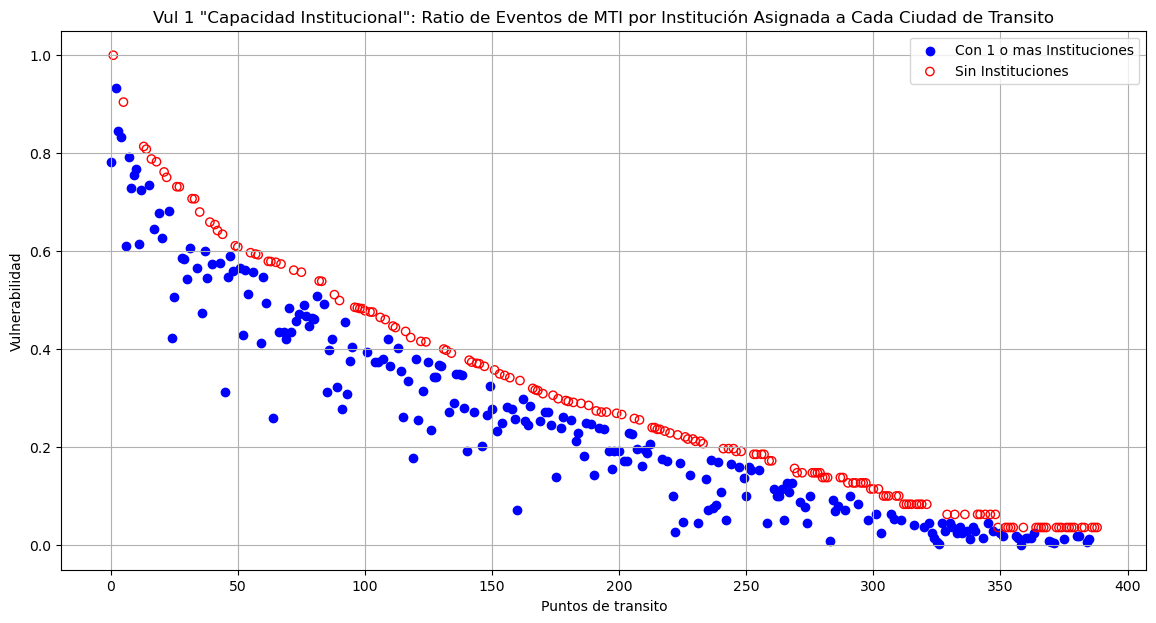

In [117]:
import matplotlib.pyplot as plt

# Configurar el tamaño de la figura según sea necesario
plt.figure(figsize=(14, 7))

# Filtrar los datos basados en la presencia de instituciones y graficar
# Puntos con instituciones
mask = dfvalores['tiene_inst'] == 1
plt.scatter(dfvalores[mask].index, dfvalores[mask]['norm_log_eventos_per_total_30km'], 
            label='Con 1 o mas Instituciones', color='blue', marker='o')

# Puntos sin instituciones (círculos vacíos)
mask = dfvalores['tiene_inst'] == 0
plt.scatter(dfvalores[mask].index, dfvalores[mask]['norm_log_eventos_per_total_30km'], 
            label='Sin Instituciones', facecolors='none', edgecolors='red', marker='o')

# Añadir detalles al gráfico
plt.title('Vul 1 "Capacidad Institucional": Ratio de Eventos de MTI por Institución Asignada a Cada Ciudad de Transito')
plt.xlabel('Puntos de transito')
plt.ylabel('Vulnerabilidad')
plt.legend()  # Añadir leyenda para identificar cada tipo de punto
plt.grid(True)  # Añadir una cuadrícula para mejorar la legibilidad

# Mostrar la gráfica
plt.show()


La métrica busca capturar la relación entre la cantidad de eventos de migrantes detectados y la capacidad institucional disponible para manejar esos eventos. Aquí detallo los aspectos clave de la métrica hasta el momento:

Definición Original de ICI:
Inicialmente, el ICI se definió como el número de eventos registrados por cada institución en un radio de 30 km (INM y SC), proporcionando un ratio directo que reflejaba la presión sobre los recursos institucionales disponibles.

Ajustes Realizados:
Transformación Logarítmica:
Propósito: Para manejar mejor la distribución asimétrica de los datos y evitar la influencia desproporcionada de valores extremos en la métrica.
Método: Se aplicó 
log
⁡
(
1
+
�
)
log(1+x) a los ratios para suavizar la variación y estabilizar la varianza en los datos.
Normalización Min-Max:
Propósito: Escalar los valores transformados a una escala de 0 a 1, facilitando la comparación entre municipios.
Método: Se normalizaron los valores ajustados de modo que el valor mínimo corresponde a 0 y el máximo a 1.
Corrección de Laplace:
Para abordar el caso de municipios sin instituciones, se añadió 1 a los conteos de instituciones (suavización de Laplace), permitiendo calcular ratios incluso en ausencia de instituciones y evitando divisiones por cero.

Interpretación de la Métrica de Vulnerabilidad:
Valores Cercanos a 1: Indican una alta vulnerabilidad, reflejando una mayor cantidad de eventos por institución después de los ajustes. Esto sugiere que las instituciones en estos municipios están potencialmente sobrecargadas o insuficientes para gestionar el volumen de eventos.
Valores Cercanos a 0: Indican una menor vulnerabilidad, sugiriendo que la relación entre eventos e instituciones es más manejable.
Valor de 0 en la Métrica Ajustada: Específicamente señala a municipios sin instituciones disponibles, destacando una situación de alta vulnerabilidad, ya que no hay capacidad institucional registrada para atender ningún evento.
Uso y Aplicaciones:
Esta métrica puede ser utilizada por autoridades y organizaciones para:

Identificar áreas críticas que requieren atención inmediata o reasignación de recursos.
Planificar de manera más efectiva la distribución de recursos y la implementación de políticas.
Monitorear y evaluar el impacto de intervenciones y mejoras en la infraestructura y servicios a lo largo del tiempo.
La vulnerabilidad, tal como se ha modelado hasta ahora, proporciona una herramienta cuantitativa para evaluar y comparar la capacidad de respuesta institucional frente a los flujos migratorios, permitiendo así una gestión más informada y focalizada de los recursos en el contexto de la migración irregular.

In [107]:
dfvalores

,nombre,ciudad,estado,latitud,longitud,codigo_ruta,ID_Poligono,codigo_unico,eventos,eventos_in_grid,...,sc_in_estado,inm_30km_adjusted,sc_30km_adjusted,log_eventos_per_inm_30km,log_eventos_per_sc_30km,log_eventos_per_total_30km,norm_log_eventos_per_inm_30km,norm_log_eventos_per_sc_30km,norm_log_eventos_per_total_30km,tiene_inst
0,"Tapachula, Chiapas","Tapachula, Chiapas",Chiapas,14.904291,-92.260926,S,PG1530,S-PG1530-8,98486,142180,...,35,3,18,10.399088,8.607481,8.453360,0.902790,0.748924,0.782794,1
1,"Huimanguillo, Tabasco","Huimanguillo, Tabasco",Tabasco,17.762097,-93.663441,G,PG1456,G-PG1456-1,97523,97523,...,0,1,1,11.487854,11.487854,10.794717,1.000000,1.000000,1.000000,0
2,"Centro, Tabasco","Centro, Tabasco",Tabasco,18.027159,-92.774791,G,PG1495,G-PG1495-6,71661,92612,...,0,2,1,10.486583,11.179716,10.081132,0.910602,0.973140,0.933801,1
3,"Acayucan, Veracruz","Acayucan, Veracruz",Veracruz,17.948786,-94.914575,G,PG1378,G-PG1378-4,45794,45863,...,12,2,3,10.038805,9.633362,9.122580,0.870623,0.838348,0.844877,1
4,"Tenosique, Tabasco","Tenosique, Tabasco",Tabasco,17.470713,-91.422021,G,PG1572,G-PG1572-3,40069,55739,...,0,2,3,9.905261,9.499821,8.989045,0.858699,0.826707,0.832489,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,"San Juan Huactzinco, Tlaxcala","San Juan Huactzinco, Tlaxcala",Tlaxcala,19.232933,-98.252038,C,PG1224,C-PG1224-2,1,5419,...,0,3,9,0.287682,0.105361,0.080043,0.000000,0.007811,0.006009,1
385,"Amaxac de Guerrero, Tlaxcala","Amaxac de Guerrero, Tlaxcala",Tlaxcala,19.348889,-98.167778,C,PG1224,C-PG1224-12,1,5419,...,0,2,4,0.405465,0.223144,0.154151,0.010516,0.018078,0.012884,1
386,"Chicomuselo, Chiapas","Chicomuselo, Chiapas",Chiapas,15.793552,-92.419266,S,PG1531,S-PG1531-1,1,1317,...,35,1,1,0.693147,0.693147,0.405465,0.036202,0.059047,0.036198,0
387,"Carlos A. Carrillo, Veracruz","Carlos A. Carrillo, Veracruz",Veracruz,18.328361,-95.715403,G,PG1339,G-PG1339-4,1,3222,...,12,1,1,0.693147,0.693147,0.405465,0.036202,0.059047,0.036198,0


### Vulnerabilidad 2

Exposición a Zona de Riesgo es una métrica diseñada para cuantificar y visualizar la exposición de las rutas migratorias a zonas de alto riesgo, considerando tanto la distancia de las rutas a estas zonas como la capacidad institucional disponible para mitigar dicho riesgo.

In [23]:
import pandas as pd
import numpy as np

In [59]:
segmentos = gpd.read_file('/Users/pablouriarte/Mapa_Migracion_Irregular_Mexico_Fresh/1. Mapas/1. Mapas/Metodo_1/procesamiento de rutas/arcos/segmentos/segmentos.shp').to_crs(epsg=4485)

In [60]:
segmentos

,Arc,Ciudad,Tipo,Municipio,distance_t,duration_t,Corrupcion,CrimenOrg,Violencia,dist_ori,dist_des,inm_30km,sc_30km,dur_ori,dur_des,geometry
0,PG1529-PG1530,"Suchiate, Chiapas",origen,Suchiate,35.6,488.0,0.0,4.0,7.0,0.000,35.561,0.0,3.0,0.000000,472.916667,POINT (2552391.749 1704801.661)
1,PG1529-PG1530,0,intermedio,Frontera Hidalgo,35.6,488.0,0.0,1.0,1.0,18.038,22.858,0.0,0.0,245.083333,305.783333,POINT (2554242.062 1718959.437)
2,PG1529-PG1530,"Tapachula, Chiapas",destino,Tapachula,35.6,488.0,6.0,67.0,122.0,35.561,0.000,2.0,17.0,487.933333,0.000000,POINT (2547519.579 1736173.639)
3,PG1530-PG1491,"Tapachula, Chiapas",origen,Tapachula,103.0,1377.0,6.0,67.0,122.0,0.000,102.700,2.0,17.0,0.000000,1388.733333,POINT (2547519.579 1736173.639)
4,PG1530-PG1491,0,intermedio,Acacoyagua,103.0,1377.0,0.0,0.0,0.0,84.140,31.879,0.0,0.0,1152.700000,451.766667,POINT (2494615.767 1791183.781)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,PG1772-PG1694,0,intermedio,Tixkokob,158.0,2160.0,0.0,1.0,1.0,134.602,29.667,0.0,0.0,1808.100000,403.133333,POINT (2788505.926 2479445.433)
1459,PG1772-PG1694,0,intermedio,Tixpéhual,158.0,2160.0,0.0,0.0,0.0,141.605,21.790,0.0,0.0,1903.233333,296.833333,POINT (2779321.719 2476196.500)
1460,PG1772-PG1694,0,intermedio,Tunkás,158.0,2160.0,0.0,1.0,0.0,65.773,95.855,0.0,0.0,884.300000,1292.883333,POINT (2858901.043 2478662.950)
1461,PG1772-PG1694,0,intermedio,Uayma,158.0,2160.0,0.0,0.0,0.0,22.664,136.086,0.0,0.0,306.683333,1832.633333,POINT (2902989.682 2472589.015)


In [61]:
import pandas as pd

# Asegurando que las columnas están presentes y renombrando algunas para claridad
segmentos.rename(columns={'distance_t': 'distancia_total', 'Violencia': 'crimen'}, inplace=True)
segmentos['instituciones'] = segmentos['inm_30km'] + segmentos['sc_30km']

# Calcular la suma de las distancias totales de todos los arcos
suma_distancia_total = segmentos['distancia_total'].sum()

# Función para calcular la vulnerabilidad para cada nodo
def calcular_vulnerabilidad(df, tipo_nodo, suma_distancia_total):
    vulnerabilidad = []
    for idx, row in df.iterrows():
        if row['Tipo'] == tipo_nodo:
            arc = row['Arc']
            nodo = row['Ciudad']
            instituciones_nodo = row['instituciones']
            distancia_total_arco = row['distancia_total']
            
            df_arco = df[df['Arc'] == arc]
            
            crimen_dista_nodo = sum(
                (p['crimen'] / (p[f'dist_{tipo_nodo[:3]}'] + 1))
                for i, p in df_arco.iterrows()
            )
            
            vulnerabilidad_nodo = (crimen_dista_nodo * (distancia_total_arco / suma_distancia_total) * (1 / (instituciones_nodo + 1)))
            vulnerabilidad.append(vulnerabilidad_nodo)
        else:
            vulnerabilidad.append(0)
    return vulnerabilidad

# Calcular vulnerabilidad para nodos de origen y destino
segmentos['vulnerabilidad_origen'] = calcular_vulnerabilidad(segmentos, 'origen', suma_distancia_total)
segmentos['vulnerabilidad_destino'] = calcular_vulnerabilidad(segmentos, 'destino', suma_distancia_total)

# Mostrar el DataFrame con las nuevas columnas de vulnerabilidad
print(segmentos[['Arc', 'Ciudad', 'Tipo', 'vulnerabilidad_origen', 'vulnerabilidad_destino']])


                Arc              Ciudad        Tipo  vulnerabilidad_origen  \
0     PG1529-PG1530   Suchiate, Chiapas      origen               0.000359   
1     PG1529-PG1530                   0  intermedio               0.000000   
2     PG1529-PG1530  Tapachula, Chiapas     destino               0.000000   
3     PG1530-PG1491  Tapachula, Chiapas      origen               0.002464   
4     PG1530-PG1491                   0  intermedio               0.000000   
...             ...                 ...         ...                    ...   
1458  PG1772-PG1694                   0  intermedio               0.000000   
1459  PG1772-PG1694                   0  intermedio               0.000000   
1460  PG1772-PG1694                   0  intermedio               0.000000   
1461  PG1772-PG1694                   0  intermedio               0.000000   
1462  PG1772-PG1694     Merida, Yucatan     destino               0.000000   

      vulnerabilidad_destino  
0                   0.000000  
1

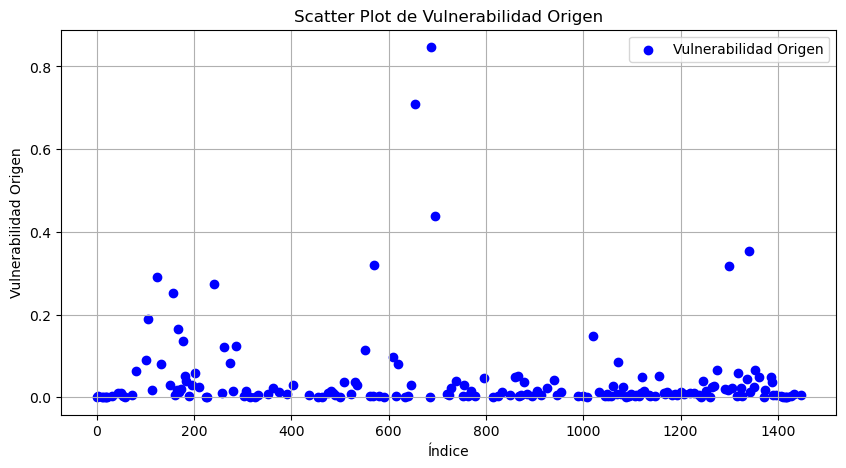

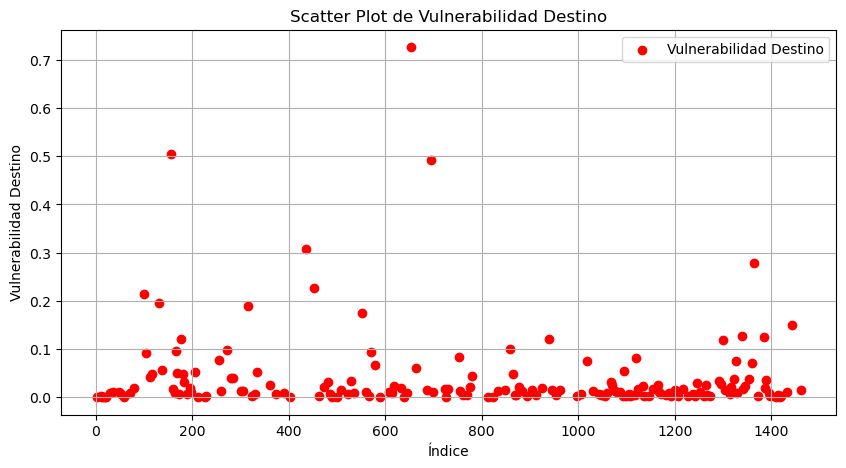

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que 'segmentos' ya contiene las columnas 'vulnerabilidad_origen' y 'vulnerabilidad_destino'
# y que los valores de vulnerabilidad ya han sido calculados.

# Filtrar los datos para eliminar filas con vulnerabilidad = 0
origen_nonzero = segmentos[segmentos['vulnerabilidad_origen'] != 0]
destino_nonzero = segmentos[segmentos['vulnerabilidad_destino'] != 0]

# Crear el scatter plot para vulnerabilidad_origen
plt.figure(figsize=(10, 5))
plt.scatter(origen_nonzero.index, origen_nonzero['vulnerabilidad_origen'], color='blue', label='Vulnerabilidad Origen')
plt.title('Scatter Plot de Vulnerabilidad Origen')
plt.xlabel('Índice')
plt.ylabel('Vulnerabilidad Origen')
plt.legend()
plt.grid(True)
plt.show()

# Crear el scatter plot para vulnerabilidad_destino
plt.figure(figsize=(10, 5))
plt.scatter(destino_nonzero.index, destino_nonzero['vulnerabilidad_destino'], color='red', label='Vulnerabilidad Destino')
plt.title('Scatter Plot de Vulnerabilidad Destino')
plt.xlabel('Índice')
plt.ylabel('Vulnerabilidad Destino')
plt.legend()
plt.grid(True)
plt.show()


In [63]:
# Filtrar los datos para eliminar filas con vulnerabilidad = 0
origen_nonzero = segmentos[segmentos['vulnerabilidad_origen'] != 0]
destino_nonzero = segmentos[segmentos['vulnerabilidad_destino'] != 0]

# Obtener las 3 filas con mayor vulnerabilidad de cada columna
top_3_origen = origen_nonzero.nlargest(3, 'vulnerabilidad_origen')
top_3_destino = destino_nonzero.nlargest(3, 'vulnerabilidad_destino')

# Obtener las 3 filas con menor vulnerabilidad de cada columna
bottom_3_origen = origen_nonzero.nsmallest(3, 'vulnerabilidad_origen')
bottom_3_destino = destino_nonzero.nsmallest(3, 'vulnerabilidad_destino')

# Imprimir los resultados
print("Top 3 filas con mayor vulnerabilidad de origen:")
print(top_3_origen[['Arc', 'Ciudad', 'Tipo', 'vulnerabilidad_origen']])

print("\nTop 3 filas con mayor vulnerabilidad de destino:")
print(top_3_destino[['Arc', 'Ciudad', 'Tipo', 'vulnerabilidad_destino']])

print("\nTop 3 filas con menor vulnerabilidad de origen:")
print(bottom_3_origen[['Arc', 'Ciudad', 'Tipo', 'vulnerabilidad_origen']])

print("\nTop 3 filas con menor vulnerabilidad de destino:")
print(bottom_3_destino[['Arc', 'Ciudad', 'Tipo', 'vulnerabilidad_destino']])


Top 3 filas con mayor vulnerabilidad de origen:
             Arc                Ciudad    Tipo  vulnerabilidad_origen
688  PG769-PG774  Chihuahua, Chihuahua  origen               0.846566
654  PG841-PG921      Durango, Durango  origen               0.709567
696  PG769-PG887  Chihuahua, Chihuahua  origen               0.438235

Top 3 filas con mayor vulnerabilidad de destino:
             Arc             Ciudad     Tipo  vulnerabilidad_destino
653  PG956-PG841   Durango, Durango  destino                0.726233
156  PG761-PG725  Culiacan, Sinaloa  destino                0.503928
695  PG769-PG774  Juarez, Chihuahua  destino                0.492655

Top 3 filas con menor vulnerabilidad de origen:
               Arc                           Ciudad    Tipo  \
814  PG1224-PG1185               Xaloztoc, Tlaxcala  origen   
20   PG1414-PG1415                Chahuites, Oaxaca  origen   
59   PG1220-PG1221  San Andres Huaxpaltepec, Oaxaca  origen   

     vulnerabilidad_origen  
814            

In [64]:
#Calcular la vulnerabilidad total por arco
segmentos['vulnerabilidad_total_arco'] = segmentos['vulnerabilidad_origen'] + segmentos['vulnerabilidad_destino']

# Agrupar por arco y sumar las vulnerabilidades
vulnerabilidad_por_arco = segmentos.groupby('Arc')['vulnerabilidad_total_arco'].sum().reset_index()

# Obtener las ciudades de origen y destino para cada arco
ciudades_arcos = segmentos[segmentos['Tipo'].isin(['origen', 'destino'])][['Arc', 'Ciudad', 'Tipo']]

# Pivotar la tabla para tener una columna para las ciudades de origen y otra para las de destino
ciudades_arcos = ciudades_arcos.pivot(index='Arc', columns='Tipo', values='Ciudad').reset_index()

# Combinar la vulnerabilidad total con las ciudades de origen y destino
vulnerabilidad_por_arco = vulnerabilidad_por_arco.merge(ciudades_arcos, on='Arc', how='left')

# Obtener los 3 arcos con mayor vulnerabilidad total
top_3_arcos = vulnerabilidad_por_arco.nlargest(3, 'vulnerabilidad_total_arco')

# Obtener los 3 arcos con menor vulnerabilidad total
bottom_3_arcos = vulnerabilidad_por_arco.nsmallest(3, 'vulnerabilidad_total_arco')

# Imprimir los resultados
print("\nTop 3 arcos con mayor vulnerabilidad total:")
print(top_3_arcos)

print("\nTop 3 arcos con menor vulnerabilidad total:")
print(bottom_3_arcos)


Top 3 arcos con mayor vulnerabilidad total:
             Arc  vulnerabilidad_total_arco                 destino  \
179  PG769-PG774                   1.339221       Juarez, Chihuahua   
184  PG841-PG921                   0.770177  Gomez Palacio, Durango   
193  PG956-PG841                   0.755538        Durango, Durango   

                   origen  
179  Chihuahua, Chihuahua  
184      Durango, Durango  
193     Calera, Zacatecas  

Top 3 arcos con menor vulnerabilidad total:
              Arc  vulnerabilidad_total_arco                   destino  \
7   PG1040-PG1081                        0.0  Piedras Negras, Coahuila   
24  PG1114-PG1116                        0.0       Apodaca, Nuevo Leon   
83  PG1261-PG1223                        0.0            Puebla, Puebla   

                            origen  
7               Monclova, Coahuila  
24           Aramberri, Nuevo Leon  
83  San Miguel Tequixtepec, Oaxaca  


In [65]:
import pandas as pd

# Supongamos que 'segmentos' ya contiene las columnas 'vulnerabilidad_origen' y 'vulnerabilidad_destino'
# y que los valores de vulnerabilidad ya han sido calculados.

# Calcular la vulnerabilidad total por arco
segmentos['vulnerabilidad_total_arco'] = segmentos['vulnerabilidad_origen'] + segmentos['vulnerabilidad_destino']

# Agrupar por arco y sumar las vulnerabilidades
vulnerabilidad_por_arco = segmentos.groupby('Arc')['vulnerabilidad_total_arco'].sum().reset_index()

# Obtener las ciudades de origen y destino para cada arco
ciudades_arcos = segmentos[segmentos['Tipo'].isin(['origen', 'destino'])][['Arc', 'Ciudad', 'Tipo']]

# Pivotar la tabla para tener una columna para las ciudades de origen y otra para las de destino
ciudades_arcos = ciudades_arcos.pivot(index='Arc', columns='Tipo', values='Ciudad').reset_index()

# Combinar la vulnerabilidad total con las ciudades de origen y destino
vulnerabilidad_por_arco = vulnerabilidad_por_arco.merge(ciudades_arcos, on='Arc', how='left')

# Obtener los 3 arcos con mayor vulnerabilidad total
top_3_arcos = vulnerabilidad_por_arco.nlargest(3, 'vulnerabilidad_total_arco')

# Obtener los 3 arcos con menor vulnerabilidad total
bottom_3_arcos = vulnerabilidad_por_arco.nsmallest(3, 'vulnerabilidad_total_arco')

# Imprimir los resultados
print("\nTop 3 arcos con mayor vulnerabilidad total:")
print(top_3_arcos)

print("\nTop 3 arcos con menor vulnerabilidad total:")
print(bottom_3_arcos)

# Filtrar el DataFrame original para mostrar las filas correspondientes a los arcos con mayor y menor vulnerabilidad total
top_arcos_ids = top_3_arcos['Arc']
bottom_arcos_ids = bottom_3_arcos['Arc']

top_arcos_nodos = segmentos[segmentos['Arc'].isin(top_arcos_ids)]
bottom_arcos_nodos = segmentos[segmentos['Arc'].isin(bottom_arcos_ids)]

print("\nNodos individuales que componen los 3 arcos con mayor vulnerabilidad total:")
print(top_arcos_nodos)

print("\nNodos individuales que componen los 3 arcos con menor vulnerabilidad total:")
print(bottom_arcos_nodos)



Top 3 arcos con mayor vulnerabilidad total:
             Arc  vulnerabilidad_total_arco                 destino  \
179  PG769-PG774                   1.339221       Juarez, Chihuahua   
184  PG841-PG921                   0.770177  Gomez Palacio, Durango   
193  PG956-PG841                   0.755538        Durango, Durango   

                   origen  
179  Chihuahua, Chihuahua  
184      Durango, Durango  
193     Calera, Zacatecas  

Top 3 arcos con menor vulnerabilidad total:
              Arc  vulnerabilidad_total_arco                   destino  \
7   PG1040-PG1081                        0.0  Piedras Negras, Coahuila   
24  PG1114-PG1116                        0.0       Apodaca, Nuevo Leon   
83  PG1261-PG1223                        0.0            Puebla, Puebla   

                            origen  
7               Monclova, Coahuila  
24           Aramberri, Nuevo Leon  
83  San Miguel Tequixtepec, Oaxaca  

Nodos individuales que componen los 3 arcos con mayor vulnerabilida

In [67]:
bottom_arcos_nodos

,Arc,Ciudad,Tipo,Municipio,distancia_total,duration_t,Corrupcion,CrimenOrg,crimen,dist_ori,dist_des,inm_30km,sc_30km,dur_ori,dur_des,geometry,instituciones,vulnerabilidad_origen,vulnerabilidad_destino,vulnerabilidad_total_arco
711,PG1040-PG1081,"Monclova, Coahuila",origen,Monclova,243.0,3240.0,46.0,587.0,80.0,0.000,242.819,0.0,0.0,0.000000,3284.466667,POINT (1454247.865 3011685.941),0.0,NaN,0.0,NaN
712,PG1040-PG1081,0,intermedio,Abasolo,243.0,3240.0,0.0,1.0,0.0,30.554,212.467,0.0,0.0,403.383333,2865.900000,POINT (1469560.716 3037802.423),0.0,0.0,0.0,0.0
713,PG1040-PG1081,0,intermedio,Allende,243.0,3240.0,6.0,95.0,11.0,NaN,NaN,0.0,0.0,NaN,NaN,POINT (1491699.305 3169620.288),0.0,0.0,0.0,0.0
714,PG1040-PG1081,0,intermedio,Escobedo,243.0,3240.0,1.0,1.0,0.0,55.402,194.247,0.0,0.0,734.333333,2618.816667,POINT (1464362.816 3058151.908),0.0,0.0,0.0,0.0
715,PG1040-PG1081,0,intermedio,Morelos,243.0,3240.0,3.0,47.0,0.0,183.833,79.385,0.0,0.0,2462.800000,1082.766667,POINT (1474469.654 3173712.480),0.0,0.0,0.0,0.0
716,PG1040-PG1081,0,intermedio,Nava,243.0,3240.0,1.0,99.0,22.0,220.566,31.993,0.0,0.0,2947.666667,437.600000,POINT (1518879.500 3196437.130),0.0,0.0,0.0,0.0
717,PG1040-PG1081,0,intermedio,Progreso,243.0,3240.0,0.0,1.0,1.0,80.585,187.508,0.0,0.0,1068.166667,2518.733333,POINT (1489113.564 3073014.534),0.0,0.0,0.0,0.0
718,PG1040-PG1081,0,intermedio,Sabinas,243.0,3240.0,8.0,371.0,37.0,124.162,124.069,0.0,0.0,1657.600000,1676.850000,POINT (1472632.466 3128111.617),0.0,0.0,0.0,0.0
719,PG1040-PG1081,0,intermedio,San Juan de Sabinas,243.0,3240.0,1.0,106.0,13.0,148.820,147.866,0.0,0.0,1992.250000,1999.100000,POINT (1446804.974 3141941.540),0.0,0.0,0.0,0.0
720,PG1040-PG1081,"Piedras Negras, Coahuila",destino,Piedras Negras,243.0,3240.0,49.0,756.0,163.0,242.804,0.000,1.0,5.0,3247.650000,0.000000,POINT (1527248.259 3220681.293),6.0,0.0,NaN,NaN
